In [52]:
import pandas as pd
import numpy as np
from itertools import cycle
import ipywidgets as widgets

import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

from scipy import interp

import sklearn
from sklearn import svm
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix, roc_curve, auc

# Classificacao de Pulsos LZ

## Suporte de cada classe

In [2]:
#Grava os dados numa Dataframe
dataframe = pd.read_csv("../Data_Challenge_1.csv", header=0)
full_dataframe = pd.read_csv("../Data_Challenge_1_full.csv", header=0)

3    692863
2    285119
1     22018
Name: pulseClass, dtype: int64


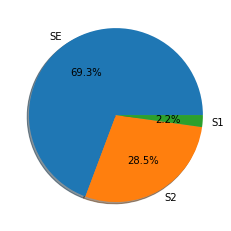

In [3]:
#Mostra a representatividade de cada class
labels = 'SE', "S2", "S1"

print(dataframe['pulseClass'].value_counts(sort=True))

plt.pie([692863, 285119, 22018], labels=labels,autopct='%1.1f%%', shadow = True)
plt.show()

In [4]:
# Dividir os dados em Treino e Teste (80%//20%)

train_data, test_data, train_lbl, test_lbl = train_test_split(dataframe.drop(["pulseClass"], axis=1), dataframe["pulseClass"], test_size=1/5.0, random_state=0)


## Normalizacao dos dados

In [5]:
#Metodo 1
def standardizeData(df):
    # copy the dataframe
    df_std = df.copy()
    
    for column in df_std.columns:
        df_std[column] = (df_std[column] - df_std[column].mean()) / df_std[column].std()
        
    return df_std

dataframe_std = standardizeData(dataframe.drop(["pulseClass"], axis=1))

In [6]:
#Metodo 2

values = dataframe.drop(["pulseClass"], axis=1).values

scaler = StandardScaler()
scaler.fit(values)

values = scaler.transform(values)
train_data, test_data, train_lbl, test_lbl = train_test_split(values, dataframe["pulseClass"], test_size=1/5.0, random_state=0)


## Estudo da correlacao dos dados

In [7]:
w_x_axis = widgets.Dropdown(
    options=list(dataframe.columns[1:]),
    description='X axis',
    disabled=False,
)

w_y_axis = widgets.Dropdown(
    options=list(dataframe.columns[1:]),
    description='Y axis',
    disabled=False,
)

display(w_x_axis)
display(w_y_axis)

Dropdown(description='X axis', options=('pA', 'pF50', 'TBA', 'pH', 'pL', 'pL90', 'aft5', 'aft25', 'aft50', 'af…

Dropdown(description='Y axis', options=('pA', 'pF50', 'TBA', 'pH', 'pL', 'pL90', 'aft5', 'aft25', 'aft50', 'af…

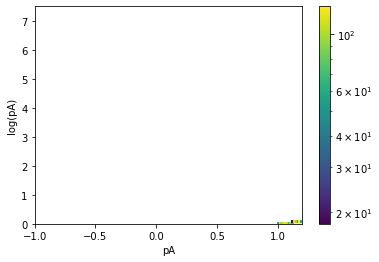

In [8]:
x = dataframe[w_x_axis.value].values
y = dataframe[w_y_axis.value].values
label = dataframe["pulseClass"].values


plt.hist2d(x, np.log10(y), bins=(np.linspace(-1.0,1.2,150), np.linspace(0.0,7.5,150)),density = True,norm=matplotlib.colors.LogNorm(), cmap=plt.cm.viridis)
plt.xlabel(w_x_axis.value)
plt.ylabel("log(" + w_y_axis.value + ")")
plt.colorbar()
plt.show()

## Selecao e reducao de Features

### Por correlacao

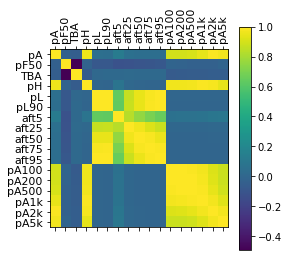

In [9]:
plt.matshow(dataframe_std.cov())
plt.xticks(range(17),dataframe_std.columns,fontsize=11,rotation=90)
plt.yticks(range(17),dataframe_std.columns,fontsize=11)
plt.colorbar()

A matrix de Covariancia mostra que os aftxx estao altamentre correlacionados entre si, assim como os pAxx. Isto significa que usar pA100 e pA200 nao vai adicionar grande informacao vs usar apenas pA100, por isso podemos ignorar features altamente correlacionadas. Mas em vez de simplesmente ignorar, podemos combinar features e tentar eliminar a correlacao entre elas. E possivel eliminar a dependencia entre os varios pAxx's se dividirmos pela area total do sinal (pA).

ADICIONAR FORMULA EM LATEX

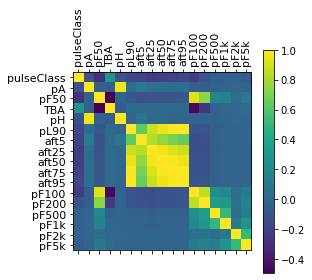

In [10]:
#Eliminar correlacao entre pAxxx

old_feat_names = ["pA100", "pA200", "pA500", "pA1k", "pA2k", "pA5k"]
new_feat_names = ["pF100", "pF200", "pF500", "pF1k", "pF2k", "pF5k"]
new_dataframe = dataframe

for i in range(6):
    
    new_dataframe[new_feat_names[i]] = dataframe[old_feat_names[i]]/dataframe['pA']

new_dataframe_std = standardizeData(new_dataframe.drop(old_feat_names, axis=1))

new_dataframe_std = new_dataframe_std.drop("pL",axis=1)

plt.matshow(new_dataframe_std.cov())
plt.xticks(range(17),new_dataframe_std.columns,fontsize=11,rotation=90)
plt.yticks(range(17),new_dataframe_std.columns,fontsize=11)
plt.colorbar()

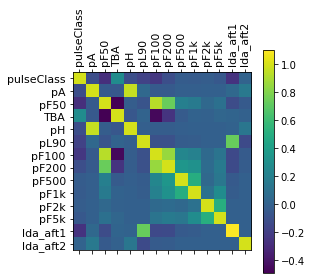

In [11]:
#Combinar os aftxx com LDA

lda = LDA(n_components=2)

lda_afts = lda.fit_transform(new_dataframe_std[["aft5","aft25", "aft50", "aft75", "aft95"]].values, dataframe["pulseClass"].values)

new_dataframe_std = new_dataframe_std.drop(["aft5","aft25", "aft50", "aft75", "aft95"], axis=1)
new_dataframe_std["lda_aft1"] = lda_afts[:,0]
new_dataframe_std["lda_aft2"] = lda_afts[:,1]

plt.matshow(new_dataframe_std.cov())
plt.xticks(range(14),new_dataframe_std.columns,fontsize=11,rotation=90)
plt.yticks(range(14),new_dataframe_std.columns,fontsize=11)
plt.colorbar()

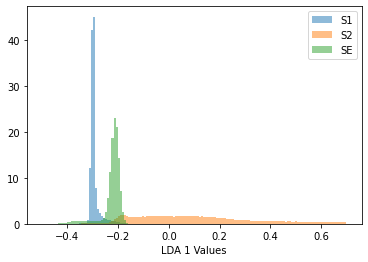

In [12]:
# now we can perform a lookup on a 'view' of the dataframe
S1 = new_dataframe_std.loc[dataframe.pulseClass==1]
S2 = new_dataframe_std.loc[dataframe.pulseClass==2]
SE = new_dataframe_std.loc[dataframe.pulseClass==3]

plt.hist(S1["lda_aft1"], bins=np.linspace(-0.5,0.7,150), alpha=0.5, density=True, label="S1")
plt.hist(S2["lda_aft1"], bins=np.linspace(-0.5,0.7,150), alpha=0.5, density=True, label="S2")
plt.hist(SE["lda_aft1"], bins=np.linspace(-0.5,0.7,150), alpha=0.5, density=True, label="SE")
plt.legend()
plt.xlabel('LDA 1 Values');

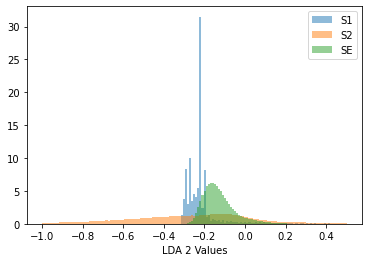

In [13]:
plt.hist(S1["lda_aft2"], bins=np.linspace(-1.0,0.5,150), alpha=0.5, density=True, label="S1")
plt.hist(S2["lda_aft2"], bins=np.linspace(-1.0,0.5,150), alpha=0.5, density=True, label="S2")
plt.hist(SE["lda_aft2"], bins=np.linspace(-1.0,0.5,150), alpha=0.5, density=True, label="SE")
plt.legend()
plt.xlabel('LDA 2 Values');

In [14]:
final_data = new_dataframe_std.drop(["pulseClass","pF100", "pF50", "pF5k"], axis = 1)


threshold_train_data, threshold_test_data, threshold_train_lbl, threshold_test_lbl = train_test_split(final_data, dataframe["pulseClass"], test_size=1/5.0, random_state=0) 

### PCA Analysis

In [15]:
pca = PCA(.99)
pca.fit(train_data)

pca_train_data = pca.transform(train_data)
pca_test_data = pca.transform(test_data)


## Random Forests

### PCA Dataset

In [16]:
pca_rf = RandomForestClassifier(random_state = 42, oob_score = True)

pca_rf.fit(pca_train_data, train_lbl);

In [17]:
pca_predictions = pca_rf.predict(pca_test_data);
acc = pca_rf.score(pca_test_data,test_lbl)

print(classification_report(test_lbl, pca_predictions))
print("Accuracy = ", acc)
print("oob error = ", 1 - pca_rf.oob_score_)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4388
           2       0.99      0.98      0.99     56898
           3       0.99      1.00      0.99    138714

    accuracy                           0.99    200000
   macro avg       1.00      0.99      0.99    200000
weighted avg       0.99      0.99      0.99    200000

Accuracy =  0.99283
oob error =  0.007367499999999971


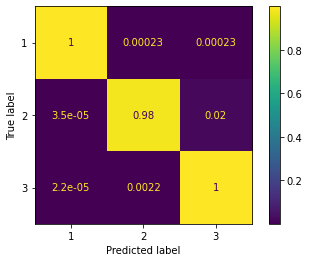

In [18]:
plot_confusion_matrix(pca_rf, pca_test_data, test_lbl, normalize = "true")
plt.show()

### Threshold Dataset

In [19]:
thr_rf = RandomForestClassifier(random_state = 42, oob_score = True)

thr_rf.fit(threshold_train_data, threshold_train_lbl);

In [20]:
thr_predictions = thr_rf.predict(threshold_test_data);
print(classification_report(threshold_test_lbl, thr_predictions))
print("oob error = ", 1 - thr_rf.oob_score_)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      4388
           2       1.00      1.00      1.00     56898
           3       1.00      1.00      1.00    138714

    accuracy                           1.00    200000
   macro avg       1.00      1.00      1.00    200000
weighted avg       1.00      1.00      1.00    200000

oob error =  9.99999999995449e-06


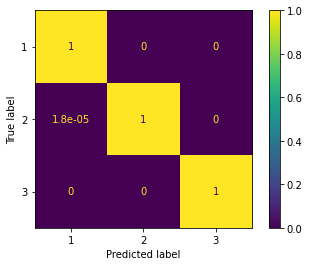

In [21]:
plot_confusion_matrix(thr_rf, threshold_test_data, threshold_test_lbl, normalize = "true")
plt.show()

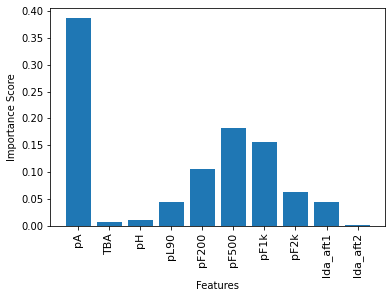

In [22]:
plt.bar(threshold_train_data.columns,thr_rf.feature_importances_)
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.xticks(fontsize=11,rotation=90)
plt.show()

## One vs All

In [61]:
y = label_binarize(dataframe["pulseClass"], classes=[1, 2, 3])
n_classes = y.shape[1]

X_train, X_test, y_train, y_test = train_test_split(final_data, y, test_size=0.9, random_state=0)

In [62]:
# Learn to predict each class against the other
classifier = OneVsRestClassifier(RandomForestClassifier(random_state = 42, oob_score = True))
y_score = classifier.fit(X_train, y_train).predict(X_test)

In [63]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

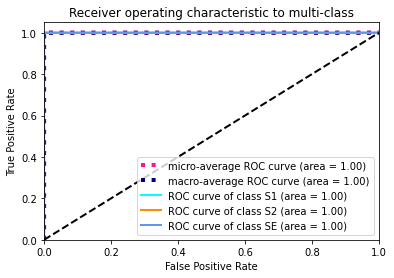

In [64]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
lw = 2
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

classes =["S1","S2", "SE"]

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [65]:
classifier.score(X_test, y_test)

0.9999522222222222